In [ ]:
!pip3 install pandas
!pip3 install requests
!pip3 install tweepy
!pip3 install matplotlib

## Gathering Data

In [1]:
import pandas as pd
import requests
import tweepy
import json
import os

1. Fetch the manually downloaded WeRateDogs Twitter archive in file `twitter_archive_enhanced.csv`

In [120]:
twitter_archive_df = pd.read_csv("twitter-archive-enhanced.csv")

2. Download the tweet image predictions file via the requests library and save as `image_predictions.tsv`

In [56]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url, allow_redirects=True)
open("image_predictions.tsv", "wb").write(response.content)

335079

3. Fetch each tweet's retweet count and favourite ("like") count, via the `Tweepy` library and save in `tweet_json.txt`

In [ ]:
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")
access_token = os.environ.get("ACCESS_TOKEN")
access_secret = os.environ.get("ACCESS_SECRET")
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [6]:
tweet_ids = list(twitter_archive_df.tweet_id)
tweets_dict = {}
for tweet_id in tweet_ids:
    try:
        status = api.get_status(
            tweet_id,
            tweet_mode="extended",
            wait_on_rate_limit=True, 
            wait_on_rate_limit_notify=True
        )
        tweets_dict[tweet_id] = status._json
    except tweepy.TweepError as e:
        print(e, tweet_id)
with open("tweet_json.json", "w") as file:
    json.dump(tweets_dict, file)

[{'code': 144, 'message': 'No status found with that ID.'}] 888202515573088257
[{'code': 144, 'message': 'No status found with that ID.'}] 873697596434513921
[{'code': 144, 'message': 'No status found with that ID.'}] 872668790621863937
[{'code': 144, 'message': 'No status found with that ID.'}] 872261713294495745
[{'code': 144, 'message': 'No status found with that ID.'}] 869988702071779329
[{'code': 144, 'message': 'No status found with that ID.'}] 866816280283807744
[{'code': 144, 'message': 'No status found with that ID.'}] 861769973181624320
[{'code': 144, 'message': 'No status found with that ID.'}] 856602993587888130
[{'code': 144, 'message': 'No status found with that ID.'}] 851953902622658560
[{'code': 144, 'message': 'No status found with that ID.'}] 845459076796616705
[{'code': 144, 'message': 'No status found with that ID.'}] 844704788403113984
[{'code': 144, 'message': 'No status found with that ID.'}] 842892208864923648
[{'code': 144, 'message': 'No status found with that

Rate limit reached. Sleeping for: 476


[{'code': 144, 'message': 'No status found with that ID.'}] 754011816964026368
[{'code': 144, 'message': 'No status found with that ID.'}] 680055455951884288


Rate limit reached. Sleeping for: 463


## Assessing Data

In [2]:
with open("tweet_json.json") as f:
    data = json.load(f)
tweets_details_df = pd.DataFrame.from_dict(data, orient="index")
tweets_details_df.reset_index(drop=True, inplace=True)
prediction_df = pd.read_csv("image_predictions.tsv", sep="\t")
twitter_archive_df = pd.read_csv("twitter-archive-enhanced.csv")

### Quality Issues with the data gathered from the tweepy library

In [3]:
# Programmitic assessment of the tweet_details dataframe. 
# tweets_details_df.shape[0]
tweets_details_df.info()
# tweets_details_df.truncated.value_counts()
# tweets_details_df.favorited.value_counts()
# tweets_details_df.retweeted.value_counts()
# tweets_details_df.lang.value_counts()
# len(tweets_details_df.full_text.iloc[0].split(' https://')[0]), tweets_details_df.display_text_range.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2332 non-null   object 
 1   id                             2332 non-null   int64  
 2   id_str                         2332 non-null   object 
 3   full_text                      2332 non-null   object 
 4   truncated                      2332 non-null   bool   
 5   display_text_range             2332 non-null   object 
 6   entities                       2332 non-null   object 
 7   extended_entities              2060 non-null   object 
 8   source                         2332 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

1. No/minimal data in columns :  `geo`, `coordinates`, `place`, `contributers`, `retweeted_status`, `quoted_status_id`, `quoted_status_id_str`, `quoted_status_permalink`, `quoted_status`, `in_reply_to_status_id`, `in_reply_to_status_id_str`, `in_reply_to_user_id`, `in_reply_to_user_id_str`, `in_reply_to_screen_name`
2. Duplicate columns `id` and `id_str`, have the same data in different data types
3. Columns like `favourited`, `retweeted`, `truncated`, `possibly_sensitive`, `possibly_sensitive_appealable` have a single value `False` for all rows.
4. `entities` and `extended_entities` have the data regarding tweets and the picture posted, this is not necessary as it's available in the `image_prediction` table.
5. `display_text_range` holds the character length of the tweet, this can be obtained from the `full_text` column itself.
6. `user` column holds the data regarding the user who made the tweet. This is not needed for our analysis, also, since all the tweets are from one account, this column will have the same data.
7. `lang` column, which tells us about the language of the tweet, is primarily english and hence can be left out.

### Quality issues with the archive data downloaded manually.

In [4]:
# Programmitic assessment of the twitter_archive_df dataframe. 
# twitter_archive_df.shape[0]
# twitter_archive_df.timestamp
# twitter_archive_df.source.value_counts()
# twitter_archive_df.text
# twitter_archive_df.rating_denominator.value_counts()
# twitter_archive_df.rating_numerator.value_counts().sort_values()
# twitter_archive_df.name.value_counts().sort_values(ascending=False)
# twitter_archive_df[twitter_archive_df.name.apply(lambda x: len(x) < 3)].name.value_counts()
# twitter_archive_df.doggo.value_counts()
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

1. Columns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, have a high number of nulls and must be deleted.
3. `source` column has the complete html tag instead of just the source value.
4. `text` column contains the tweet content and the link to the tweet. Must be seperated.
5. We have a few tweets where the numerator or the denominator is below 10, and some tweets where the numerator is enormously high.
7. `name` column has 745 values as `None`, 55 as `a` and 7 as `an`.
8. `expanded_urls` has 59 invalid links (nan) and random samples of urls lead to non-existant pages.

### Quality issues with the prediction data.

In [6]:
# prediction_df.shape
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


1. `img_num` is not useful for our analysis.
2. Some pictures are those that are not dogs, hence must be removed based on probability.
3. Duplicates in `jpg_url` column must be removed.

### Tidiness issues

1. Except for `retweet_count` and `favorite_count` in dataframe `tweets_details_df`, all the data is present in the `twitter_archive_df`. Must merge the dataframes.
2. `tweet_id` should ideally be in string ( object ) data type as we will not be performing mathematical operations on it.
3. `jpg_url` in the `prediction_df` dataframe should ideally be in the `twitter_archive_df`.
4. The archival data ( `twitter_archive_df` - len = 2356 ) has 24 more rows than `tweets_details` (2332). So those 24 rows must be removed. Also, `prediction_df` has only 2075 rows.
5. `prediction_df` has three levels of prediction, can be combined into a single categorical variable (isDog) of categories - "Yes", "No", "Maybe".
6. Stages of dogs can be combined into one categorical variable.

Total tables/dataframes in the end = 1.

## Cleaning Data

1. Remove unwanted columns from the three dataframes. 

In [3]:
tweets_details_df.drop(
    [
        "in_reply_to_status_id_str",
        "in_reply_to_status_id",
        "in_reply_to_user_id_str",
        "in_reply_to_user_id",
        "in_reply_to_screen_name",
        "geo",
        "coordinates",
        "place",
        "contributors",
        "retweeted_status",
        "is_quote_status",
        "quoted_status_id",
        "quoted_status_id_str",
        "quoted_status_permalink",
        "quoted_status",
        "truncated",
        "possibly_sensitive_appealable",
        "possibly_sensitive",
        "favorited",
        "retweeted",
        "extended_entities",
        "id_str",
        "display_text_range",
        "entities",
        "user",
        "lang",
        "created_at",
        "full_text",
        "source",
    ],
    axis=1,
    inplace=True
)
twitter_archive_df.drop(
    [
        "in_reply_to_status_id",
        "in_reply_to_user_id",
        "retweeted_status_id",
        "retweeted_status_user_id",
        "retweeted_status_timestamp",
        "expanded_urls"
    ],
    axis=1,
    inplace=True
)
prediction_df.drop(
    [
        "img_num"
    ],
    axis=1,
    inplace=True
)

In [4]:
prediction_df.shape[0], tweets_details_df.shape[0], twitter_archive_df.shape[0]

(2075, 2332, 2356)

1. Remove rows present in `tweets_details_df`, but not in `twitter_archive_df` and merge taking `retweet_count` and `favorite_count`.

In [5]:
twitter_archive_df.rename(columns={'tweet_id': 'id'}, inplace=True)
extra_rows = pd.concat([twitter_archive_df.id, tweets_details_df.id])
extra_rows.drop_duplicates(keep=False, inplace=True)
extra_rows = list(extra_rows)
twitter_archive_updated = twitter_archive_df.query("id not in @extra_rows")
twitter_archive_updated.shape, tweets_details_df.id.nunique()

((2332, 11), 2332)

In [6]:
twitter_archive_updated = twitter_archive_updated.merge(tweets_details_df, left_on='id', right_on='id')
twitter_archive_updated.shape, twitter_archive_updated.id.nunique()

((2332, 13), 2332)

3. Remove duplicate `jpg_url` rows from `prediction_df` and merge them.

In [7]:
prediction_df.rename(columns={'tweet_id': 'id'}, inplace=True)
prediction_df.drop_duplicates(subset="jpg_url", keep="first", inplace=True)
prediction_df.shape

(2009, 11)

In [8]:
# Remove rows present in archive but not in prediction.
extra_rows = pd.concat([twitter_archive_updated.id, prediction_df.id])
extra_rows.drop_duplicates(keep=False, inplace=True)
extra_rows = list(extra_rows)
twitter_archive_updated = twitter_archive_updated.query("id not in @extra_rows")
twitter_archive_updated.shape, twitter_archive_updated.id.nunique()

((2001, 13), 2001)

In [9]:
twitter_archive_updated = twitter_archive_updated.merge(prediction_df, left_on='id', right_on='id')
twitter_archive_updated.shape, twitter_archive_updated.id.nunique()

((2001, 23), 2001)

4. Convert data type of tweet_id column from `int64` to `object` and remove column id

In [10]:
twitter_archive_updated.id = twitter_archive_updated.id.apply(str)
twitter_archive_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2001 non-null   object 
 1   timestamp           2001 non-null   object 
 2   source              2001 non-null   object 
 3   text                2001 non-null   object 
 4   rating_numerator    2001 non-null   int64  
 5   rating_denominator  2001 non-null   int64  
 6   name                2001 non-null   object 
 7   doggo               2001 non-null   object 
 8   floofer             2001 non-null   object 
 9   pupper              2001 non-null   object 
 10  puppo               2001 non-null   object 
 11  retweet_count       2001 non-null   int64  
 12  favorite_count      2001 non-null   int64  
 13  jpg_url             2001 non-null   object 
 14  p1                  2001 non-null   object 
 15  p1_conf             2001 non-null   float64
 16  p1_dog

5. Seperate url and text from `text` in `twitter_archive_updated`.

In [11]:
twitter_archive_updated["text"] = twitter_archive_updated.text.str.split(r'https?://', expand=True)[0]

6. Remove tweets of not dogs and retweets

In [12]:
remove = []
remove.extend(list(twitter_archive_updated[twitter_archive_updated.text.str.contains("we only rate")].id))
remove.extend(list(twitter_archive_updated[twitter_archive_updated.text.str.contains("We only rate")].id))
remove.extend(list(twitter_archive_updated[twitter_archive_updated.text.str.contains("We don't rate")].id))
remove.extend(list(twitter_archive_updated[twitter_archive_updated.text.str.startswith("RT @")].id))
remove.extend(list(twitter_archive_updated[twitter_archive_updated.text.str.contains("not a dog")].id))
# remove.extend(list(twitter_archive_updated.query("rating_numerator <= 7").id))
twitter_archive_updated = twitter_archive_updated.query("id not in @remove")
twitter_archive_updated.shape[0]

1931

In [13]:
# Tweets with rating < 5, that are not dogs
remove = []
remove.extend([527, 618, 724, 894, 963, 973, 1055, 1100, 1219, 1242, 1300, 1307, 1359, 1426, 1485, 1504, 1512, 1523, 1651,
    1656, 1659, 1671, 1716, 1765, 1780, 1814, 1816, 1836, 1863, 1879, 1884, 1890, 1900, 1908, 1912, 1923])
# Tweets with rating == 5, that are not dogs
remove.extend([1048, 1205, 1234, 1239, 1257, 1289, 1331, 1401, 1450, 1463, 1491, 1509, 1561, 1595, 1608, 1689, 
              1714, 1719, 1732, 1769, 1784, 1819])
# Tweets with rating == 6, that are not dogs
remove.extend([164, 811, 911, 1016, 1037, 1041, 1313, 1358, 1429, 1554, 1568, 1574, 1615, 1621, 1625, 
              1699, 1736, 1851, 1896, 1904])
# Tweets with rating == 7, that are not dogs
remove.extend([744, 909, 999, 1034, 1132, 1181, 1201, 1280, 1293, 1333, 1538, 1541, 1547, 1563, 1635, 1668, 1687,
              1763, 1789, 1835])
# Tweets with rating == 8, that are not dogs
remove.extend([579, 680, 701, 755, 1005, 1179, 1208, 1342, 1400, 1476, 1500, 1530, 1543, 1585, 1590, 1611, 1629,
              1632, 1643, 1677, 1761, ])
twitter_archive_updated.drop(remove, inplace=True)
twitter_archive_updated.shape

(1812, 23)

7. Normalise the rating scale ( denominator = 10 and numerator <= 15 ).

In [14]:
# tweets with denominator more than 10 - 16 records
rating_denominator_gt_10 = twitter_archive_updated.query("rating_denominator > 10")
rating_denominator_gt_10["divi"] = rating_denominator_gt_10.rating_numerator / rating_denominator_gt_10.rating_denominator
ids = rating_denominator_gt_10.id
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "rating_numerator"] = int(rating_denominator_gt_10.loc[rating_denominator_gt_10["id"] == id].divi * 10)
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "rating_denominator"] = 10

/home/devajji/Desktop/Udacity/Data-Wrangling/.env/lib64/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# tweets with numerator more than 15 - 18 records
rating_numerator_gt_15 = twitter_archive_updated.query("rating_numerator > 15")
ids = rating_numerator_gt_15.id
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "rating_numerator"] = 15
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "rating_denominator"] = 10

In [16]:
# twitter_archive_updated.query("rating_numerator > 15")
# twitter_archive_updated.query("rating_denominator < 10")
# twitter_archive_updated.query("rating_denominator > 10")
# twitter_archive_updated[twitter_archive_updated.text.str.contains("Bluebert")]
twitter_archive_updated[twitter_archive_updated.text.str.contains("420")].id # Snoop Dogg
# twitter_archive_updated[twitter_archive_updated.text.str.contains("battalion")]
# twitter_archive_updated[twitter_archive_updated.text.str.contains("mugged")]
# twitter_archive_updated[twitter_archive_updated.text.str.contains("Please")]
twitter_archive_updated.shape

(1812, 23)

In [17]:
twitter_archive_updated.drop(1723, inplace=True) # Snoop Dogg

In [18]:
twitter_archive_updated.loc[twitter_archive_updated["id"] == "716439118184652801", "rating_numerator"] = 11
twitter_archive_updated.loc[twitter_archive_updated["id"] == "716439118184652801", "rating_denominator"] = 10
twitter_archive_updated.loc[twitter_archive_updated["id"] == "680494726643068929", "rating_numerator"] = 11
twitter_archive_updated.loc[twitter_archive_updated["id"] == "680494726643068929", "rating_denominator"] = 10
# denominator less than 10.
twitter_archive_updated.loc[twitter_archive_updated["id"] == "810984652412424192", "rating_denominator"] = 10
# denominator greater than 10
twitter_archive_updated.loc[twitter_archive_updated["id"] == "740373189193256964", "rating_numerator"] = 14
twitter_archive_updated.loc[twitter_archive_updated["id"] == "740373189193256964", "rating_denominator"] = 10


In [19]:
# Remove rating_denominator column as all have same value = 10
twitter_archive_updated.drop("rating_denominator", axis=1, inplace=True)
twitter_archive_updated.rename(columns={"rating_numerator": "rating"}, inplace=True)

In [20]:
twitter_archive_updated.shape, twitter_archive_updated.id.nunique()

((1811, 22), 1811)

8. Convert stages of dogs into a single categorical variable

In [21]:
stages_df = twitter_archive_updated[["id", "doggo", "puppo", "pupper", "floofer"]].copy()
stages_dict = {}
ids = list(stages_df.id)
for i in ids:
    rec = stages_df.query("id == @i")
    if rec.doggo.iloc[0] != "None":
        stages_dict[i] = rec.doggo.iloc[0]
    elif rec.puppo.iloc[0] != "None":
        stages_dict[i] = rec.puppo.iloc[0]
    elif rec.pupper.iloc[0] != "None":
        stages_dict[i] = rec.pupper.iloc[0]
    elif rec.floofer.iloc[0] != "None":
        stages_dict[i] = rec.floofer.iloc[0]
    else:
        stages_dict[i] = "None"
stages_df = pd.DataFrame.from_dict(stages_dict, orient="index")
stages_df.reset_index(inplace=True)
stages_df.rename(columns={0:"stage"}, inplace=True)

In [22]:
twitter_archive_updated = twitter_archive_updated.merge(stages_df, left_on="id", right_on="index")

9. Drop redundant columns

In [23]:
twitter_archive_updated.drop(["doggo", "puppo", "pupper", "floofer", "index"], axis=1, inplace=True)

10. Convert prediction columns into a single categorical variable `isDog` of categories `Yes`, `No`, `Maybe`

In [24]:
prediction_updated = twitter_archive_updated[["id", "jpg_url", "p1", "p1_conf", "p1_dog", "p2", "p2_conf", "p2_dog", "p3", "p3_conf", "p3_dog",]]

In [25]:
no = []
no.extend(list(prediction_updated.query("p1_dog == False and p2_dog == False and p3_dog == False").id))
maybe = []
maybe.extend(list(prediction_updated.query("p1_dog == True and p2_dog == False and p3_dog == False").id))
maybe.extend(list(prediction_updated.query("p1_dog == False and p2_dog == True and p3_dog == False").id))
maybe.extend(list(prediction_updated.query("p1_dog == False and p2_dog == False and p3_dog == True").id))
maybe.extend(list(prediction_updated.query("p1_dog == True and p2_dog == True and p3_dog == False").id))
maybe.extend(list(prediction_updated.query("p1_dog == False and p2_dog == True and p3_dog == True").id))
maybe.extend(list(prediction_updated.query("p1_dog == True and p2_dog == False and p3_dog == True").id))
yes = []
yes.extend(list(prediction_updated.query("p1_dog == True and p2_dog == True and p3_dog == True").id))

In [26]:
prediction_dict = dict()
ids = list(prediction_updated.id)
for idx in ids:
    if idx in no:
        prediction_dict[idx] = "No"
    elif idx in maybe:
        prediction_dict[idx] = "Maybe"
    elif idx in yes:
        prediction_dict[idx] = "Yes"
prediction_category_df = pd.DataFrame.from_dict(prediction_dict, orient="index")
prediction_category_df.reset_index(inplace=True)
prediction_category_df.rename(columns={0:"isDog"}, inplace=True)

In [27]:
twitter_archive_updated = twitter_archive_updated.merge(prediction_category_df, left_on="id", right_on="index")

In [28]:
twitter_archive_updated.drop(
    [
        "p1_dog", "p1_conf", "p2_dog", "p2", "p2_conf", "p3_conf", "p3_dog", "p3", "index"
    ],
    axis=1,
    inplace=True
)

In [29]:
twitter_archive_updated.rename(columns={"p1": "prediction"}, inplace=True)

In [30]:
twitter_archive_updated.head()

,id,timestamp,source,text,rating,name,retweet_count,favorite_count,jpg_url,prediction,stage,isDog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,Phineas,7674,36054,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,None,No
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,Tilly,5674,31087,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,None,Yes
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,Archie,3761,23395,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,None,Yes
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,Darla,7840,39308,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,None,Maybe
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,Franklin,8445,37533,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,None,Yes


11. Extract value from html tags of the `source` column.

In [31]:
twitter_archive_updated.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1778
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       24
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
Name: source, dtype: int64

In [32]:
ids = list(twitter_archive_updated[twitter_archive_updated.source.str.contains("iPhone")].id)
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "source"] = "Twitter for iPhone"
ids = list(twitter_archive_updated[twitter_archive_updated.source.str.contains("TweetDeck")].id)
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "source"] = "TweetDeck"
ids = list(twitter_archive_updated[twitter_archive_updated.source.str.contains("Web Client")].id)
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "source"] = "Twitter Web Client"

In [33]:
print(twitter_archive_updated.source.value_counts())
twitter_archive_updated.info()

Twitter for iPhone    1778
Twitter Web Client      24
TweetDeck                9
Name: source, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1811 non-null   object
 1   timestamp       1811 non-null   object
 2   source          1811 non-null   object
 3   text            1811 non-null   object
 4   rating          1811 non-null   int64 
 5   name            1811 non-null   object
 6   retweet_count   1811 non-null   int64 
 7   favorite_count  1811 non-null   int64 
 8   jpg_url         1811 non-null   object
 9   prediction      1811 non-null   object
 10  stage           1811 non-null   object
 11  isDog           1811 non-null   object
dtypes: int64(3), object(9)
memory usage: 183.9+ KB


12. Discrepancies in `name` column - All names either start with a capital letter or are `None`.

In [34]:
ids = list(twitter_archive_updated[twitter_archive_updated.name.str.contains('^[a-z]')].id)
for id in ids:
    twitter_archive_updated.loc[twitter_archive_updated["id"] == id, "name"] = "None"

In [35]:
twitter_archive_updated.head()

,id,timestamp,source,text,rating,name,retweet_count,favorite_count,jpg_url,prediction,stage,isDog
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,Phineas,7674,36054,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,None,No
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,Tilly,5674,31087,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,None,Yes
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,Archie,3761,23395,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,None,Yes
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,Darla,7840,39308,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,None,Maybe
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,Franklin,8445,37533,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,None,Yes


13. Convert `timestamp` column into `datetime` format and remove the time part.

In [36]:
twitter_archive_updated.timestamp = pd.to_datetime(twitter_archive_updated.timestamp, infer_datetime_format=True).dt.normalize()
twitter_archive_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1811 non-null   object        
 1   timestamp       1811 non-null   datetime64[ns]
 2   source          1811 non-null   object        
 3   text            1811 non-null   object        
 4   rating          1811 non-null   int64         
 5   name            1811 non-null   object        
 6   retweet_count   1811 non-null   int64         
 7   favorite_count  1811 non-null   int64         
 8   jpg_url         1811 non-null   object        
 9   prediction      1811 non-null   object        
 10  stage           1811 non-null   object        
 11  isDog           1811 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 183.9+ KB


14. Rename the columns ( camelCase )

In [37]:
twitter_archive_updated.rename(columns={
    "timestamp": "date",
    "retweet_count": "retweetCount",
    "favorite_count": "favoriteCount",
    "jpg_url": "jpgURL",
}, inplace=True)
twitter_archive_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             1811 non-null   object        
 1   date           1811 non-null   datetime64[ns]
 2   source         1811 non-null   object        
 3   text           1811 non-null   object        
 4   rating         1811 non-null   int64         
 5   name           1811 non-null   object        
 6   retweetCount   1811 non-null   int64         
 7   favoriteCount  1811 non-null   int64         
 8   jpgURL         1811 non-null   object        
 9   prediction     1811 non-null   object        
 10  stage          1811 non-null   object        
 11  isDog          1811 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 183.9+ KB


14. Store the cleaned dataset into a csv file. 

In [38]:
twitter_archive_cleaned = twitter_archive_updated[
    [
        "id",
        "date",
        "source",
        "text",
        "jpgURL",
        "name",
        "stage",
        "rating",
        "prediction",
        "isDog",
        "retweetCount",
        "favoriteCount"]
]
twitter_archive_cleaned.to_csv("twitter_archive_cleaned.csv", index=False)

## Analysis and Visualization

In [39]:
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn')
%matplotlib inline

In [40]:
twitter_archive_cleaned = pd.read_csv("twitter_archive_cleaned.csv")
twitter_archive_cleaned.date = pd.to_datetime(twitter_archive_cleaned.date, infer_datetime_format=True)

In [41]:
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             1811 non-null   int64         
 1   date           1811 non-null   datetime64[ns]
 2   source         1811 non-null   object        
 3   text           1811 non-null   object        
 4   jpgURL         1811 non-null   object        
 5   name           1811 non-null   object        
 6   stage          1811 non-null   object        
 7   rating         1811 non-null   int64         
 8   prediction     1811 non-null   object        
 9   isDog          1811 non-null   object        
 10  retweetCount   1811 non-null   int64         
 11  favoriteCount  1811 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 169.9+ KB


#### 1. Distribution of ratings

Average Rating :  10.56874654886803


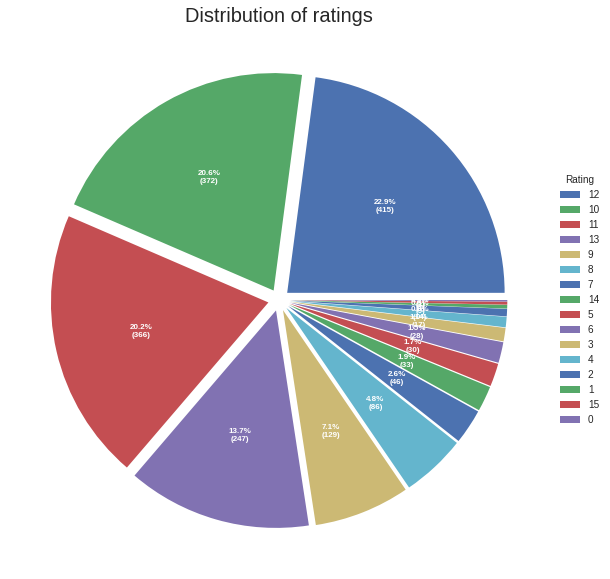

In [42]:
print("Average Rating : ", np.average(twitter_archive_cleaned.rating))
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

data = list(twitter_archive_cleaned.rating.value_counts().to_dict().values())
ingredients = list(twitter_archive_cleaned.rating.value_counts().to_dict().keys())
explode = (0.05, ) * len(data)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, explode=explode, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Rating",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Distribution of ratings", size=20)

plt.show()

The average rating is `10.5` and the most common rating is `12`, followed by `10` and `11`

#### 2. Distribution of ReTweets and Favorites

In [43]:
max(twitter_archive_cleaned.retweetCount), max(twitter_archive_cleaned.favoriteCount)

(77452, 155458)

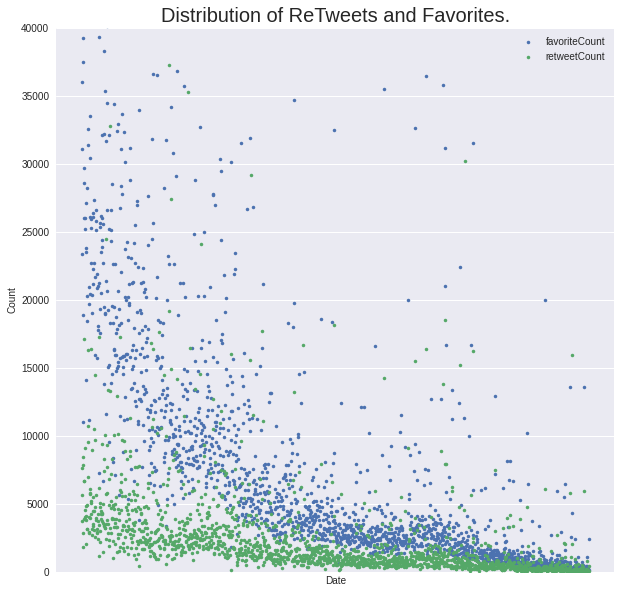

In [44]:
twitter_archive_cleaned[['favoriteCount', 'retweetCount']].plot(style =
'.', ylim=[0, 40000], figsize=(10,10))
plt.title('Distribution of ReTweets and Favorites.', size=20)
plt.xlabel('Date', size=10)
plt.xticks([], [])
plt.ylabel('Count', size=10)
plt.legend(ncol=1, loc='upper right')
plt.show()

We observe the following:
1. The number of favorites and retweets has dropped over the years ( 2015 - 2017 ).
2. The number of favorites is more than retweets, though they start to even out as time passed.

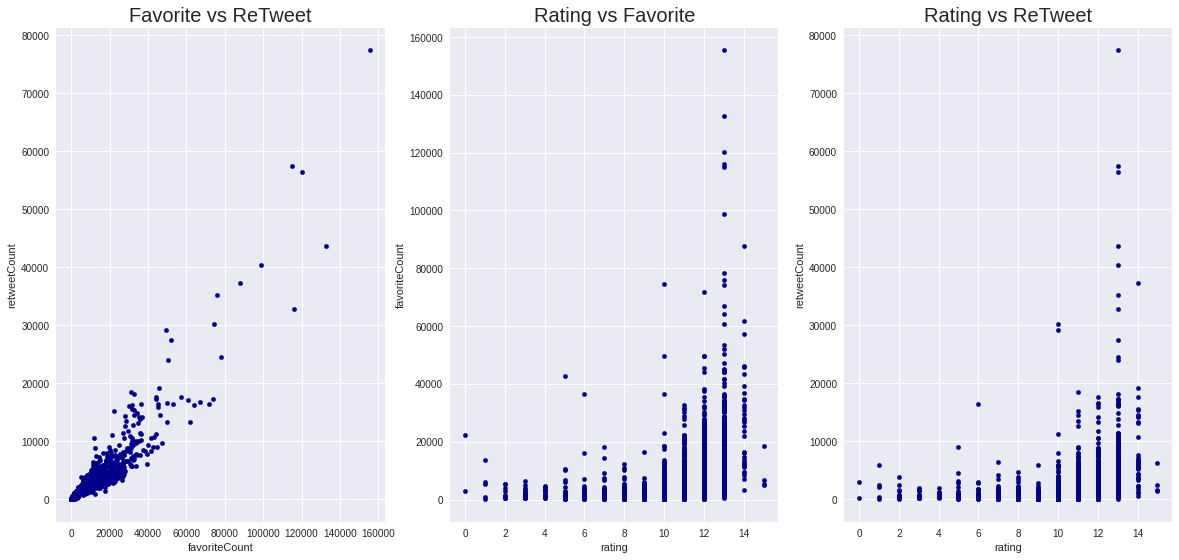

In [45]:
fig = plt.figure()
ax = fig.add_subplot(231)
twitter_archive_cleaned.plot.scatter(
    x='favoriteCount', y='retweetCount', c='DarkBlue', ax=ax, figsize=(8, 5)
).set_title('Favorite vs ReTweet', fontsize=20)
ax = fig.add_subplot(232)
twitter_archive_cleaned.plot.scatter(
    x='rating', y='favoriteCount', c='DarkBlue', ax=ax, figsize=(20, 20)
).set_title('Rating vs Favorite', fontsize=20)
ax = fig.add_subplot(233)
twitter_archive_cleaned.plot.scatter(
    x='rating', y='retweetCount', c='DarkBlue', ax=ax, figsize=(20, 20)
).set_title('Rating vs ReTweet', fontsize=20);

We observe the following:
1. ReTweets and favorites are directly proportional, the more the retweets means the more it gets favourited.
2. The Dogs that are rated in between `11 - 14` are favourited and retweeted more than other dogs.

#### 3. Distribution of Sources

In [46]:
twitter_archive_cleaned.source.value_counts()

Twitter for iPhone    1778
Twitter Web Client      24
TweetDeck                9
Name: source, dtype: int64

It is clearly evident that, `Twitter for iPhone` is the most common source (98.17%) of tweets. Closely followed
by `Twitter Web Client`. `TweetDeck` has the least number of tweets.

#### 4. Distribution of Dogs.

In [47]:
from IPython.display import Image
from IPython.core.display import HTML 
twitter_archive_cleaned.query("rating == 15")

,id,date,source,text,jpgURL,name,stage,rating,prediction,isDog,retweetCount,favoriteCount
362,810984652412424192,2016-12-19,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspir...,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,Sam,None,15,golden_retriever,Yes,1461,5412
478,786709082849828864,2016-10-13,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Logan,None,15,Pomeranian,Maybe,6217,18500
524,778027034220126208,2016-09-20,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,Sophie,pupper,15,clumber,Yes,1633,6612
687,749981277374128128,2016-07-04,TweetDeck,This is Atticus. He's quite simply America af....,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,Atticus,None,15,bow_tie,No,2464,5112


The following is the image of the dog which is rated the highest (15), and has a high number of favorites and retweets amongst dogs ranked 15.

It's a picture of a dog named Logan.

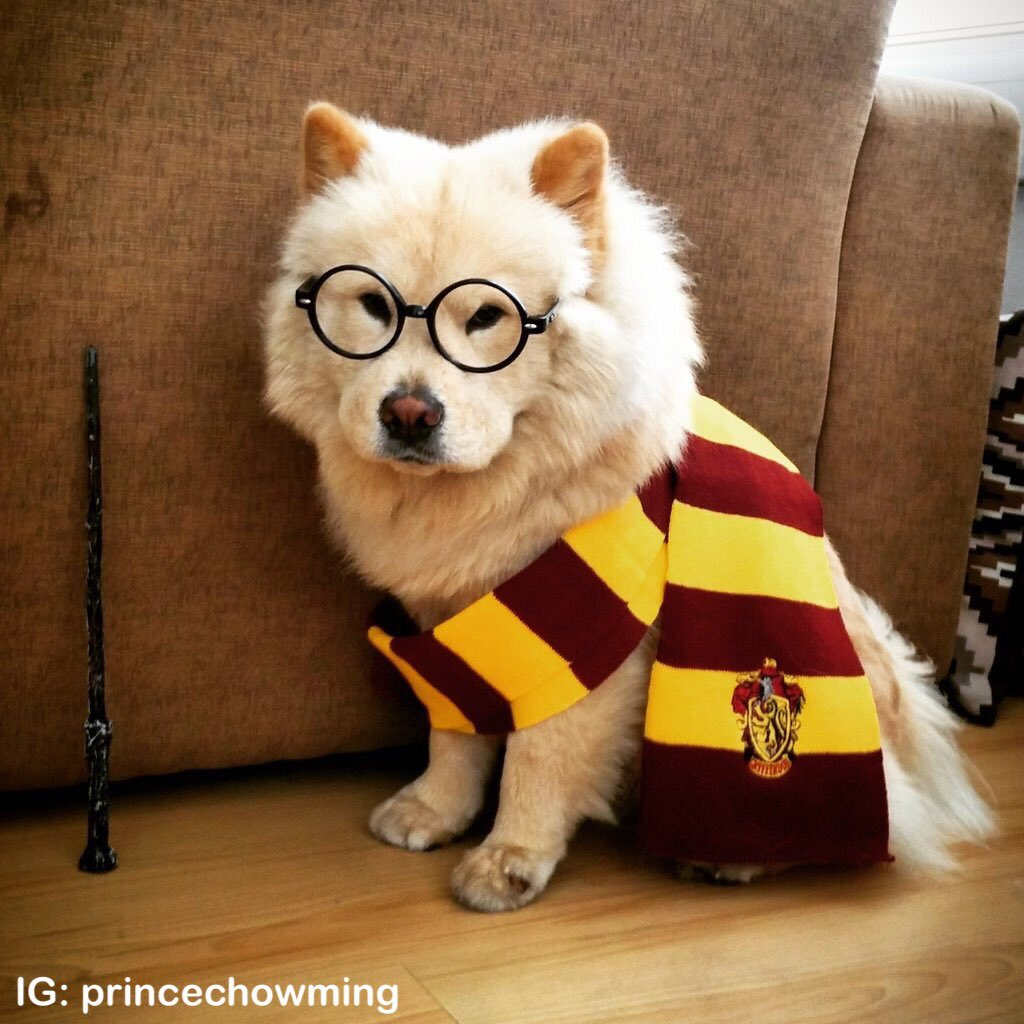

In [48]:
Image(url='https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg', embed=True, width=300, height=300)

The most reTweeted picture also is the most favorited.

It is a picture of a Labrador_retriever swimming.

In [49]:
max_retweet_count = twitter_archive_cleaned.retweetCount.max()
twitter_archive_cleaned.query("retweetCount == @max_retweet_count")

,id,date,source,text,jpgURL,name,stage,rating,prediction,isDog,retweetCount,favoriteCount
731,744234799360020481,2016-06-18,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,https://pbs.twimg.com/ext_tw_video_thumb/74423...,None,doggo,13,Labrador_retriever,Maybe,77452,155458


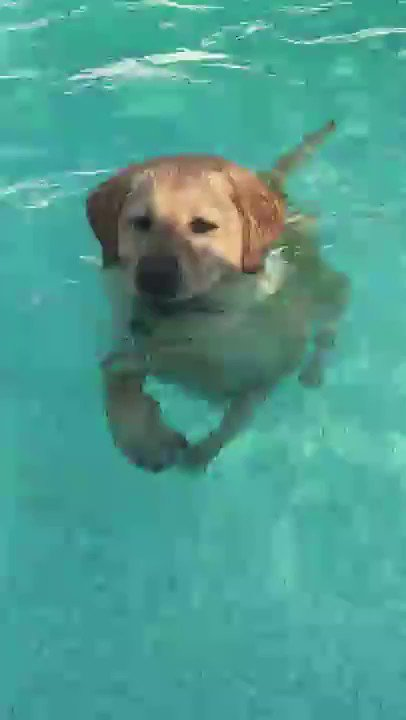

In [50]:
Image(
    url='https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg',
    embed=True,
    width=300,height=300
)

In [51]:
twitter_archive_cleaned.name.value_counts()

None       538
Charlie     10
Oliver      10
Cooper      10
Tucker       9
          ... 
Corey        1
Al           1
JD           1
Rilo         1
Mimosa       1
Name: name, Length: 864, dtype: int64

Cooper and Charlie are the most common dog names, though a majority of tweets have dogs without a name.

In [52]:
twitter_archive_cleaned.prediction.value_counts()

golden_retriever       125
Labrador_retriever      84
Pembroke                80
Chihuahua               74
pug                     48
                      ... 
African_hunting_dog      1
shield                   1
water_buffalo            1
radio_telescope          1
panpipe                  1
Name: prediction, Length: 359, dtype: int64

Retrievers are the most common dog breeds that are rated. Golden Retriever, Labrador Retriever closely followed by
Pembroke.